# Случайные процессы. Прикладной поток.
## Практическое задание 3

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 5"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: 5.N.ipynb и 5.N.pdf, где N — ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.

** Варианты: **

0) http://ita.ee.lbl.gov/html/contrib/ClarkNet-HTTP.html 

1) http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html

2) http://ita.ee.lbl.gov/html/contrib/Calgary-HTTP.html 

3) http://ita.ee.lbl.gov/html/contrib/Sask-HTTP.html

Нужно выбрать вариант $N\mod{4}$, где 𝑁 — ваш номер из таблицы с оценками.

Задание:
1. Загрузите в Питоне данные, соответствующие вашему варианту. Возможно, будет удобнее воспользоваться библиотекой pandas, в частности функцией read_csv. Некоторые записи в данных могут иметь неправильный формат, поэтому сначала файл с данными придется преобразовать. В процессе преобразовании можно проигнорировать не более 1% строк, в которых указана дата (если будете удалять, напечатайте долю удаленных строк). Строки, в которых дата не указана, нужно удалить.
2. Переведите дату в timestamp-число с помощью библиотеки datetime. Например, дата 24/Oct/1994:13:41:41 преобразуется в число 782995301 с помощью кода
from datetime import datetime
datetime.strptime("24/Oct/1994:13:41:41", "%d/%b/%Y:%H:%M:%S").timestamp() Подробнее читайте в документациях к библиотекам datetime и time.
3. Запросы, происходящие в некоторые моменты времени, образуют пуассоновский про- цесс, смысл которого — количество запросов, обработанных сервером к текущему мо- менту времени. Нарисуйте графики траектории этого пуассоновского процесса за все время и за первые сутки. Нарисуйте так же аналогичные графики составного пуассо- новского процесса, взяв в качестве значений количество байт (bytes in the reply). При построении графиков используйте код с семинара.
4. Проверьте полученный пуассоновский процесс на однородность за все время, а так же за некоторые другие интервалы времени (месяц, неделя, сутки, час). Имеются ли интервалы, на которых процесс однороден? Чтобы проверить корректность работы реализованных критериев, можно проверить их на сгенерированных данных. Код для генерации можно взять с семинара.
5. Постройте оценку функции интенсивности следующим образом. Разбейте весь вре- менной интервал на небольшие равные по длине интервалы с достаточным количе- ством событий в каждом интервале (например, интерваля длинною в час). На каждом интервале оцените значение интенсивности процесса, считая его однородным на дан- ном интервале. В какие моменты времени наблюдается наибольшая интенсивность?
6. Для получения дополнительных баллов исследуйте, есть ли зависимость интенсив- ности от типа хоста (host); есть ли зависимость объема запроса в байтах от времени; какой пропускной способности должны быть серверы, чтобы обрабатывать все по- ступающие запросы.

При проведении исследования учитывайте все особенности проверки статистических гипотез. Не забывайте делать выводы.

In [51]:
import pandas as pd
from io import StringIO
from datetime import datetime
import re
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import csv

from bisect import bisect_right
from bisect import bisect_left

%matplotlib inline

1) Загрузите в Питоне данные, соответствующие вашему варианту. Возможно, будет удобнее воспользоваться библиотекой pandas, в частности функцией read_csv. Некоторые записи в данных могут иметь неправильный формат, поэтому сначала файл с данными придется преобразовать. В процессе преобразовании можно проигнорировать не более 1% строк, в которых указана дата (если будете удалять, напечатайте долю удаленных строк). Строки, в которых дата не указана, нужно удалить.

In [2]:
source_data = None
with open("data_source.txt", encoding="latin1") as data_file:
    formatted_data_io = StringIO()
    for line in data_file:
        splitted = line.split('"')
        prepared = []
        prepared.append(re.sub('[\[,\]]', '{', splitted[0]))
        prepared.append('{' + '"'.join(splitted[1:-1]) + '{')
        prepared.append(splitted[-1])
        
        formatted_data_io.write("".join(prepared))
    formatted_data_io.seek(0)
    source_data = pd.read_csv(formatted_data_io, 
                              sep=' ', quotechar='{', 
                              header=None,
                              error_bad_lines=False, low_memory=False)
source_data.head()

b'Skipping line 1229617: expected 7 fields, saw 8\nSkipping line 1242667: expected 7 fields, saw 8\nSkipping line 2099491: expected 7 fields, saw 8\nSkipping line 2099557: expected 7 fields, saw 8\nSkipping line 2099560: expected 7 fields, saw 8\n'


,0,1,2,3,4,5,6
0,202.32.92.47,-,-,01/Jun/1995:00:00:59 -0600,GET /~scottp/publish.html,200,271
1,ix-or7-27.ix.netcom.com,-,-,01/Jun/1995:00:02:51 -0600,GET /~ladd/ostriches.html,200,205908
2,ram0.huji.ac.il,-,-,01/Jun/1995:00:05:44 -0600,GET /~scottp/publish.html,200,271
3,eagle40.sasknet.sk.ca,-,-,01/Jun/1995:00:08:06 -0600,GET /~lowey/,200,1116
4,eagle40.sasknet.sk.ca,-,-,01/Jun/1995:00:08:19 -0600,GET /~lowey/kevin.gif,200,49649


Немного подправим исходный файл в данных строчках чтобы легче было распарсить файл

In [9]:
source_data = None
with open("data.txt", encoding="latin1") as data_file:
    formatted_data_io = StringIO()
    for line in data_file:
        splitted = line.split('"')
        prepared = []
        prepared.append(re.sub('[\[,\]]', '{', splitted[0]))
        prepared.append('{' + '"'.join(splitted[1:-1]) + '{')
        prepared.append(splitted[-1])
        
        formatted_data_io.write("".join(prepared))
    formatted_data_io.seek(0)
    source_data = pd.read_csv(formatted_data_io, 
                       names=['Hostname', '-', 'Nickname', 'Datetime', 'Request', 'Code', 'Size'],
                       sep=' ', quotechar='{', 
                       error_bad_lines=False, low_memory=False)
source_data.head()

,Hostname,-,Nickname,Datetime,Request,Code,Size
0,202.32.92.47,-,-,01/Jun/1995:00:00:59 -0600,GET /~scottp/publish.html,200,271
1,ix-or7-27.ix.netcom.com,-,-,01/Jun/1995:00:02:51 -0600,GET /~ladd/ostriches.html,200,205908
2,ram0.huji.ac.il,-,-,01/Jun/1995:00:05:44 -0600,GET /~scottp/publish.html,200,271
3,eagle40.sasknet.sk.ca,-,-,01/Jun/1995:00:08:06 -0600,GET /~lowey/,200,1116
4,eagle40.sasknet.sk.ca,-,-,01/Jun/1995:00:08:19 -0600,GET /~lowey/kevin.gif,200,49649


2) Переведите дату в `timestamp`-число с помощью библиотеки `datetime`. Например, дата `24/Oct/1994:13:41:41` преобразуется в число `782995301` с помощью кода 

from datetime import datetime 

datetime.strptime("24/Oct/1994:13:41:41", "%d/%b/%Y:%H:%M:%S").timestamp() 

Подробнее читайте в документациях к библиотекам `datetime` и `time`.

In [10]:
def timestamp(source):
    try:
        return datetime.strptime(source, "%d/%b/%Y:%H:%M:%S").timestamp()
    except:
        return None
def integer(source):
    try:
        return int(source)
    except:
        return None

In [11]:
data = source_data[['Hostname', 'Datetime', 'Size']]
data['Datetime'] = data['Datetime'].apply(
    lambda x: timestamp(str(x).split(' ')[0]))
data['Size'] = data['Size'].apply(lambda x: integer(x))
data = data.sort('Datetime')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [12]:
data[np.isnan(data['Datetime'])]

,Hostname,Datetime,Size
1229616,maz3.maz.net,NaN,NaN
1242667,129.186.123.55,NaN,NaN


In [13]:
data = data[data['Datetime'].notnull()]

In [14]:
data.head()

,Hostname,Datetime,Size
0,202.32.92.47,801950459.0,271.0
1,ix-or7-27.ix.netcom.com,801950571.0,205908.0
2,ram0.huji.ac.il,801950744.0,271.0
3,eagle40.sasknet.sk.ca,801950886.0,1116.0
4,eagle40.sasknet.sk.ca,801950899.0,49649.0


3) Запросы, происходящие в некоторые моменты времени, образуют пуассоновский процесс, смысл которого --- количество запросов, обработанных сервером к текущему моменту времени. Нарисуйте графики траектории этого пуассоновского процесса за все время и за первые сутки. Нарисуйте так же аналогичные графики составного пуассоновского процесса, взяв в качестве значений количество байт (`bytes in the reply`). При построении графиков используйте код с семинара.

In [79]:
def get_data(source, from_val=None, to_val=None):
    left = 0
    right = len(source)
    if from_val is not None:
        left = bisect_left(source, from_val)
    if to_val is not None:
        right = bisect_right(source, to_val)
    filtred = np.array(source[left:right])
    return filtred

In [94]:
first_day_data = data[np.array(timestamp("01/Jun/1995:00:00:00") \
                               <= data['Datetime']) & \
                      np.array(timestamp("02/Jun/1995:00:00:00") \
                               > data['Datetime'])]

In [16]:
def draw_trajectory(jumps, label=None, lw=5):
    plt.figure(figsize=(15, 7))
    
    plt.hlines(np.arange(len(jumps) - 1), 
               jumps[:-1], jumps[1:], 
               label=label, lw=lw, color='blue')

    plt.xticks(fontsize=12), plt.xlabel('Время', 
                                        fontsize=14)
    plt.yticks(fontsize=12), plt.ylabel('Количество событий', 
                                        fontsize=14)
    plt.title('График траектории пуассоновского процесса для '\
              + str(len(jumps)) + ' событий', 
              y=1.03, fontsize=20)

    if label is not None:
        plt.legend(fontsize=12, loc='upper left')
    plt.grid(ls=':')
    plt.show()

In [81]:
def draw_trajectory(jumps, values=None, label=None, lw=5):
    plt.figure(figsize=(15, 7))
    
    jumps = jumps - jumps[0]
    if values is None:
        values = np.arange(len(jumps) - 1)
    else:
        values = values - values[0]
    
    plt.hlines(values, 
               jumps[:-1], jumps[1:], 
               label=label, lw=lw, color='blue')

    plt.xticks(fontsize=12), plt.xlabel('Время', 
                                        fontsize=14)
    plt.yticks(fontsize=12), plt.ylabel('Количество событий', 
                                        fontsize=14)
    plt.title('График траектории пуассоновского процесса для '\
              + str(len(jumps)) + ' событий', 
              y=1.03, fontsize=20)

    if label is not None:
        plt.legend(fontsize=12, loc='upper left')
    plt.grid(ls=':')
    plt.show()

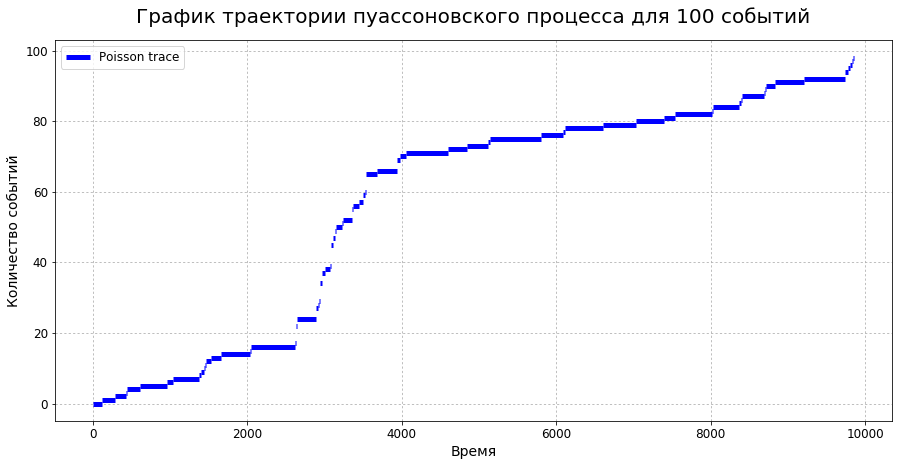

In [82]:
draw_trajectory(data['Datetime'][:100], label='Poisson trace')

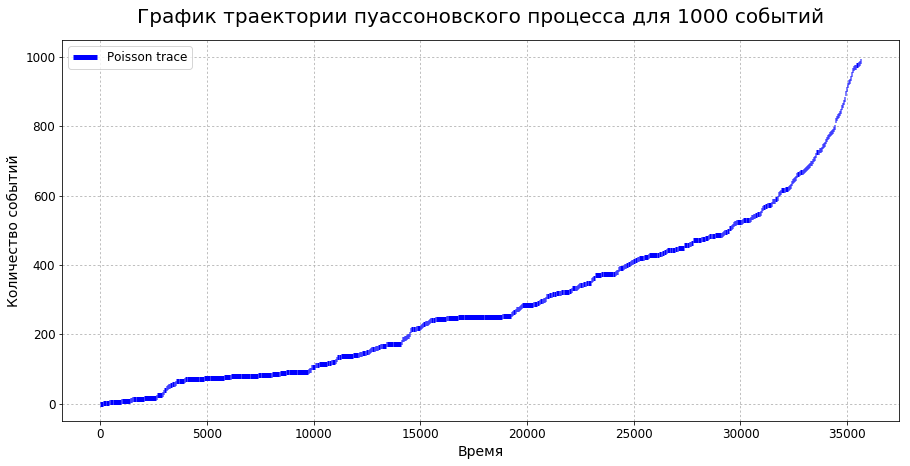

In [19]:
draw_trajectory(data['Datetime'][:1000], label='Poisson trace')

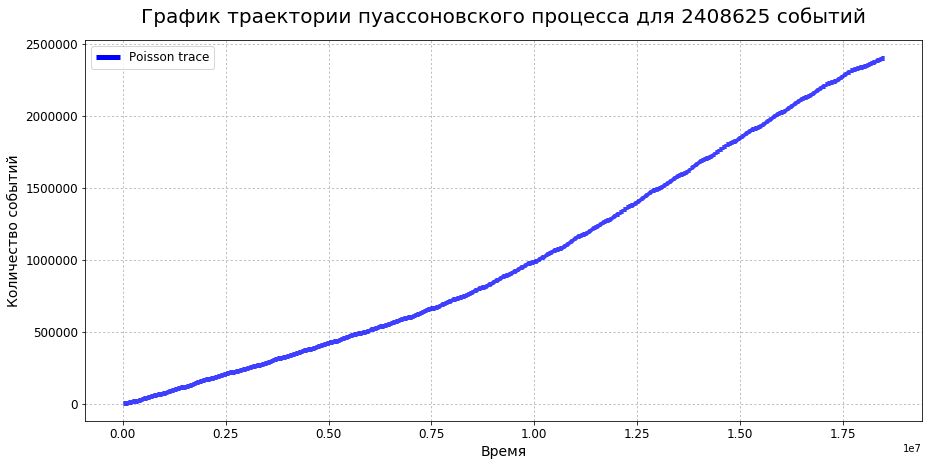

In [20]:
draw_trajectory(data['Datetime'], label='Poisson trace', lw=5)

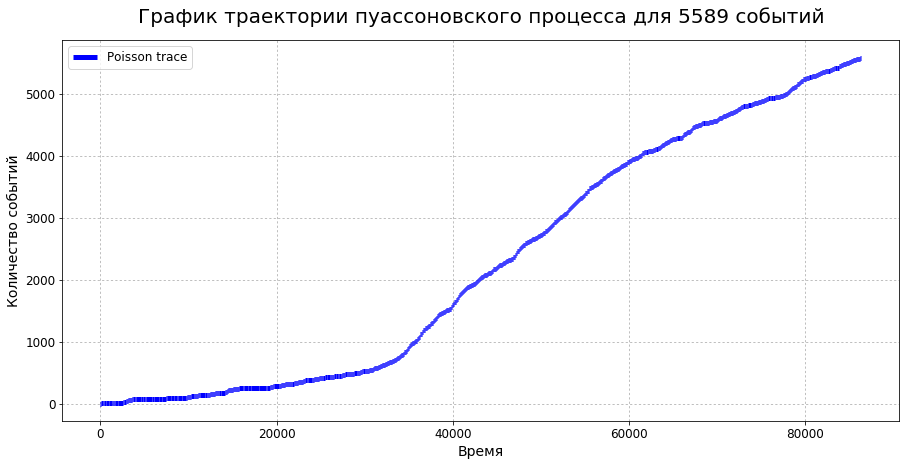

In [95]:
draw_trajectory(first_day_data['Datetime'], label='Poisson trace')

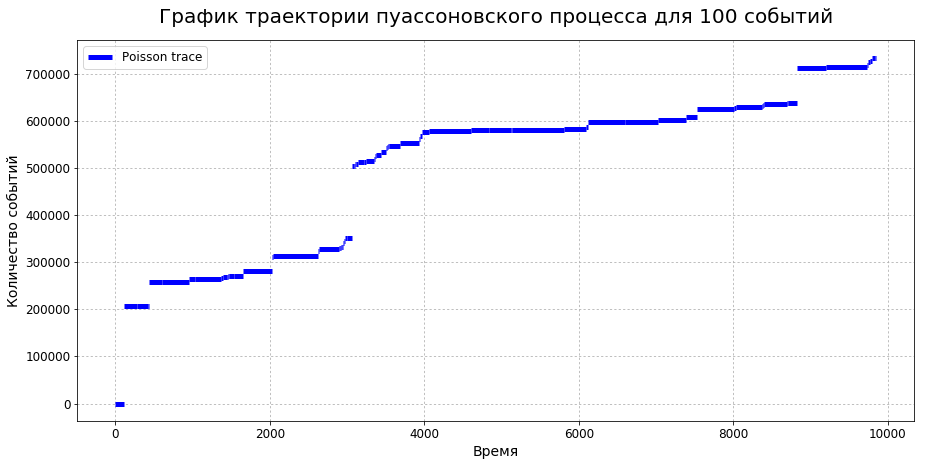

In [22]:
draw_trajectory(data['Datetime'][:100], 
                values=data['Size'][:100-1].cumsum(), 
                label='Poisson trace')

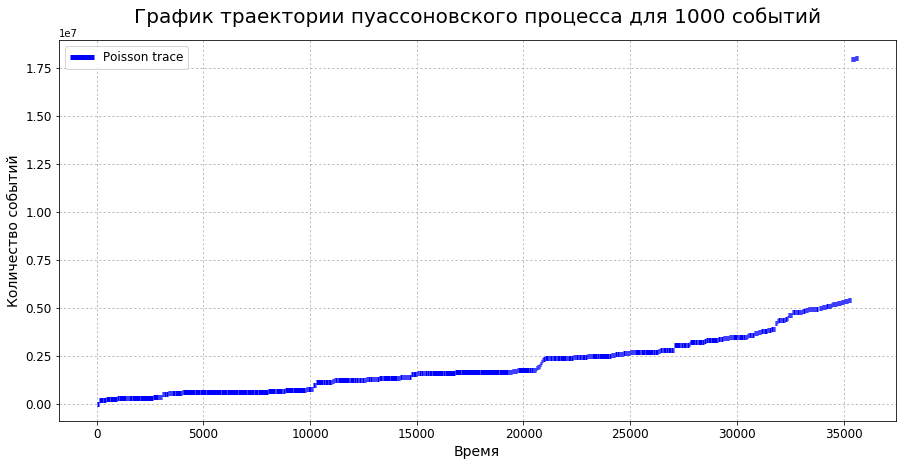

In [23]:
draw_trajectory(data['Datetime'][:1000], 
                values=data['Size'][:1000-1].cumsum(), 
                label='Poisson trace')

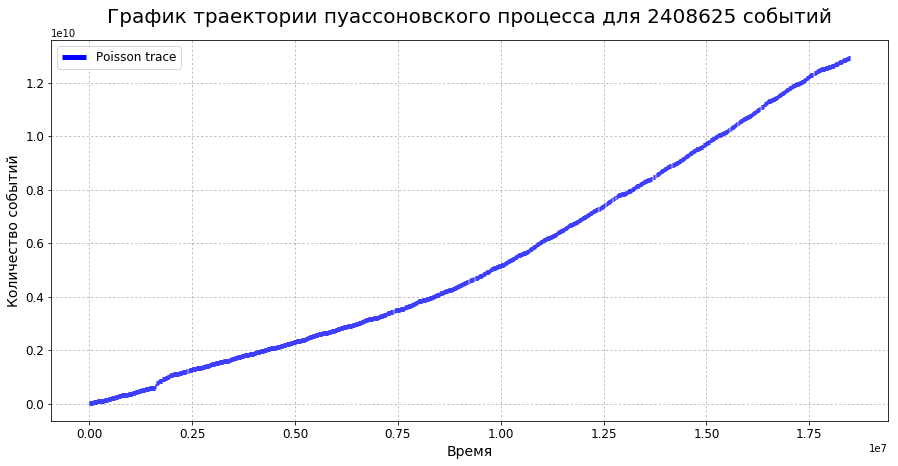

In [24]:
draw_trajectory(data['Datetime'], 
                values=data['Size'][:-1].cumsum(), 
                label='Poisson trace')

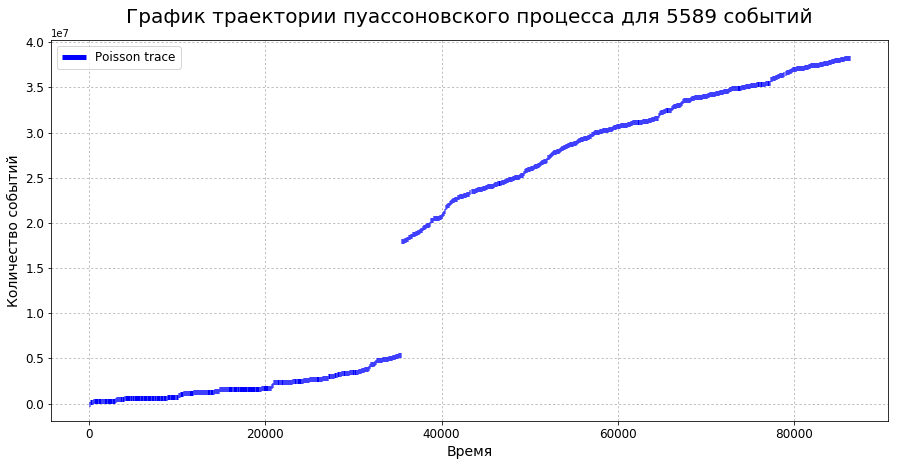

In [96]:
draw_trajectory(first_day_data['Datetime'], 
                values=first_day_data['Size'][:-1].cumsum(), 
                label='Poisson trace')

4) Проверьте полученный пуассоновский процесс на однородность за все время, а так же за некоторые другие интервалы времени (месяц, неделя, сутки, час). Имеются ли интервалы, на которых процесс однороден? Чтобы проверить корректность работы реализованных критериев, можно проверить их на сгенерированных данных. Код для генерации можно взять с семинара.

Если предположить, что $T_i$ --- времена скачков некоторого пуассоновского процесса с интенсивностью $\lambda$, то:
* $\tau_i \, \left(= T_i - T_{i - 1}\right) \sim Exp\left(\lambda\right)$
* $T_i \sim Gamma\left(n, \lambda\right)$
Тогда
$$ \frac{\sum_{i = 1}^{n} \tau_i}{n} \longrightarrow_{n \to \infty} E\left[\tau_1\right] = \frac{1}{\lambda} $$
$$ \frac{n}{\sum_{i = 1}^{n} \tau_i} \longrightarrow_{n \to \infty} \lambda $$
Рассмотрим математическое ожидание нашей оценки
$$ E\left[\frac{n}{\sum_{i = 1}^{n} \tau_i}\right] = E\left[\frac{n}{T_n}\right] = n \int_0^{+\infty} \frac{x^{n-2}}{\Gamma\left(n\right)}\lambda^ne^{-\lambda x}dx = n\frac{\lambda \Gamma\left(n - 1\right)}{\Gamma\left(n\right)} \underbrace{\int_0^{+\infty} \frac{x^{n-2}}{\Gamma\left(n-1\right)}\lambda^{n-1}e^{-\lambda x}dx}_{=1} = \frac{n}{n-1}\lambda$$
Следовательно $\lambda = \frac{n - 1}{\sum_{i = 1}^{n} \tau_i}$ --- несмещенная оценка

In [462]:
def count_data(sample, delim):
    sample.sort()
    counts = [0]
    for d in delim:
        counts.append(bisect_right(sample, d))
    counts = np.array(counts)
    return counts[1:] - counts[:-1]

In [696]:
def lambda_assessment(source):
    taus = source[1:] - source[:-1]
    taus_sum = sum(taus)
    if taus_sum != 0:
        return (len(taus) - 1) / (sum(taus))
    return np.nan

In [887]:
def uniformity_test(source, lambd, bins=None):
    source = np.array(source)
    
    if bins is None:
        bins = int(len(source) / 5)
        
    jumps = np.array(sorted(source[1:] - source[:-1]))
    
    f_exp = np.ones(bins, 
                    dtype=np.float64) / bins
    delim = list(map(
        lambda p: sps.expon(scale=1/lambd).ppf(p), 
                     f_exp.cumsum()))
    ctest = sps.chisquare(count_data(jumps, delim), 
                          f_exp=f_exp * len(jumps))
        
    return ctest

Для проверки работоспособности нашего метода проверим ее на сгенерированной выборке

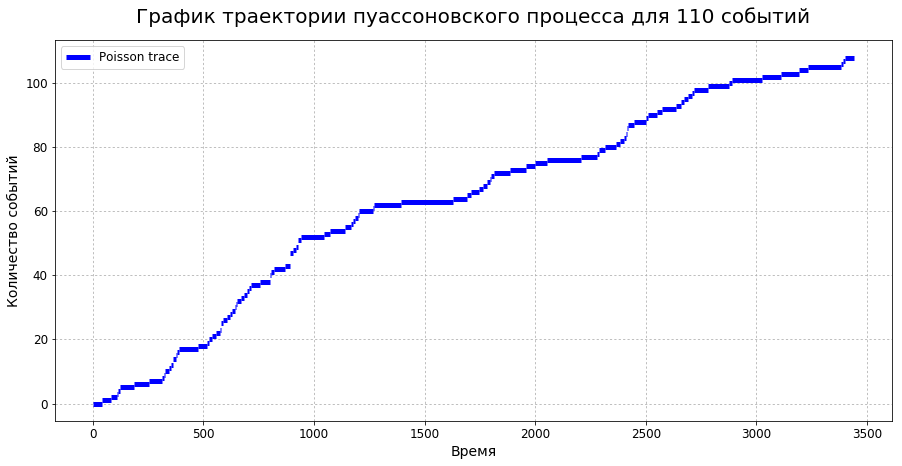

In [875]:
day_data = data[np.array(timestamp("06/Jun/1995:02:00:00") \
                         <= data['Datetime']) & \
                np.array(timestamp("06/Jun/1995:03:00:00") \
                         >  data['Datetime'])]

draw_trajectory(np.array(day_data['Datetime']), label='Poisson trace')

In [935]:
def generate_poisson_process(T, lambd):
    S = 0
    xi = [0]  # тут будут случайные величины \xi_i. Ноль для удобства
    while S < T:
        xi.append(sps.expon(scale=1/lambd).rvs())
        S += xi[-1]
    jumps = np.cumsum(xi)  # моменты скачков
    return jumps

In [937]:
for i in range(100): 
    jumps = generate_poisson_process(2000, 
                    (np.random.randint(100) + 1) / 10)
    ctest = uniformity_test(jumps, 
                            lambda_assessment(jumps))
    if ctest.pvalue >= 0.05:
        print("He отвергается", end=" ")
    else:
        print("ОТВЕРГАЕТСЯ", end=" ")

He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается ОТВЕРГАЕТСЯ ОТВЕРГАЕТСЯ He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается ОТВЕРГАЕТСЯ He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается ОТВЕРГАЕТСЯ He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отвергается He отве

Отвергается лишь $5$ из $100$

Проверим окажется ли весь процесс однородным

In [944]:
times = np.array(data['Datetime'])
ctest = uniformity_test(times, 
                        lambda_assessment(times))
if ctest.pvalue >= 0.05:
    print("Не отвергается")
else:
    print("Отвергается")

Отвергается


Далее проанализируем месяцы на однородность, будем сдвигать с шагом в день

In [938]:
SECONDS_IN_HOUR = 60 * 60
SECONDS_IN_DAY = SECONDS_IN_HOUR * 24
SECONDS_IN_MOUNTH = SECONDS_IN_DAY * 30

In [939]:
datetimes = np.array(data['Datetime'])
begin = timestamp("01/Jun/1995:00:00:00")
end   = begin + SECONDS_IN_MOUNTH

left = 0
right = 0
not_refuted_mounthes = []

while end <= datetimes[-1]:
    while left < len(datetimes) and datetimes[left] < begin:
        left += 1
    while right < len(datetimes) and datetimes[right] <= end:
        right += 1
        
    mounth_times = datetimes[left:right]
    if len(mounth_times) > 0:
        mounth_times -= mounth_times[0]
        ctest = uniformity_test(mounth_times, 
                                lambda_assessment(mounth_times))

        if ctest.pvalue >= 0.05:
            not_refuted_mounthes.append(begin)
    begin += SECONDS_IN_DAY
    end += SECONDS_IN_DAY

In [940]:
print(len(not_refuted_mounthes))

0


Ни одного промежутка длинною в месяц не нашлось. Теперь дни

In [941]:
datetimes = np.array(data['Datetime'])
begin = timestamp("01/Jun/1995:00:00:00")
end   = begin + SECONDS_IN_DAY

left = 0
right = 0
not_refuted_days = []

while end <= datetimes[-1]:
    while left < len(datetimes) and datetimes[left] < begin:
        left += 1
    while right < len(datetimes) and datetimes[right] <= end:
        right += 1
        
    hour_times = datetimes[left:right]
    if len(hour_times) > 0:
        hour_times -= hour_times[0]
        ctest = uniformity_test(hour_times, 
                                lambda_assessment(hour_times))

        if ctest.pvalue >= 0.05:
            not_refuted_days.append(begin)
    begin += SECONDS_IN_DAY
    end += SECONDS_IN_DAY

In [942]:
print(len(not_refuted_days))

0


Дней тоже, и наконец часы но уже с шагом в час

In [914]:
datetimes = np.array(data['Datetime'])
begin = timestamp("01/Jun/1995:00:00:00")
end   = begin + SECONDS_IN_HOUR

left = 0
right = 0
not_refuted = []
last_p = 0

while end <= datetimes[-1]:
#     if int((begin - timestamp("01/Jun/1995:00:00:00")) / (datetimes[-1] - timestamp("01/Jun/1995:00:00:00")) * 100) != last_p:
#         last_p = int((begin - timestamp("01/Jun/1995:00:00:00")) / (datetimes[-1] - timestamp("01/Jun/1995:00:00:00")) * 100)
#         print(last_p, end=' ')
    while left < len(datetimes) and datetimes[left] < begin:
        left += 1
    while right < len(datetimes) and datetimes[right] <= end:
        right += 1
        
    hour_times = datetimes[left:right]
    if len(hour_times) > 0:
        hour_times -= hour_times[0]
        ctest = uniformity_test(hour_times, 
                                lambda_assessment(hour_times))

        if ctest.pvalue >= 0.05:
            not_refuted.append(begin)
    begin += SECONDS_IN_HOUR
    end += SECONDS_IN_HOUR

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [921]:
print(len(not_refuted))

84


Оказывается такие часы есть

5) Постройте оценку функции интенсивности следующим образом. Разбейте весь временной интервал на небольшие равные по длине интервалы с достаточным количеством событий в каждом интервале (например, интерваля длинною в час). На каждом интервале оцените значение интенсивности процесса, считая его однородным на данном интервале. В какие моменты времени наблюдается наибольшая интенсивность?

Будем двигаться с шагом в час и собирать массив из интенсивностей по уже выведенной оценке

In [698]:
left = 0

intencitis = []

times = np.array(data['Datetime'] \
                 - timestamp("01/Jun/1995:00:00:00"))
current = SECONDS_IN_HOUR
for i in range(len(times)):
    if times[i] > current:
        intencitis.append(lambda_assessment(times[left:i]))
        left = i
        current += SECONDS_IN_HOUR
intencitis.append(lambda_assessment(times[left:]))
intencitis = np.array(intencitis)

Построим гистограммы для первых двух недель.

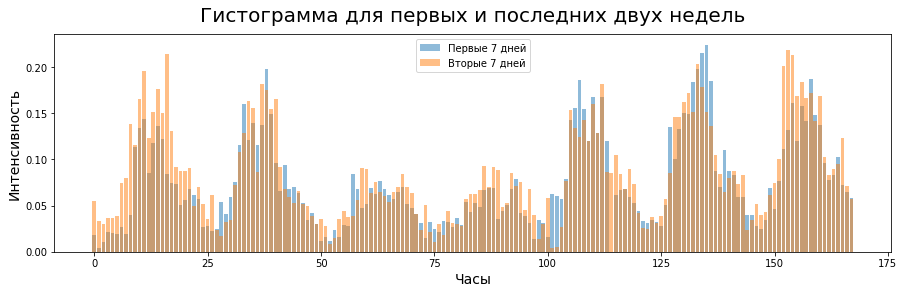

In [760]:
plt.figure(figsize=(15, 4))

plt.bar(np.arange(0, len(intencitis[:168])), 
        intencitis[:168],
        alpha=0.5, label='Первые 7 дней')
plt.bar(np.arange(0, len(intencitis[168:336])), 
        intencitis[168:336],
        alpha=0.5, label='Вторые 7 дней')


plt.xlabel('Часы', fontsize=14)
plt.ylabel('Интенсивность', fontsize=14)
plt.title ('Гистограмма для первых и последних двух недель', 
          y=1.03, fontsize=20)

plt.legend()
plt.show()

Как можно обнаружить интенсивность имеет переодическую зависимость от времени, это объяснякется тем, что ночью запросов практически не наблюдается и чаще всего они где-то в середине дня. Также заметен некий спад в середине гистограммы, похоже что данные дни были выходными ($1$ Июля $1995$ года --- это четверг, и первый день измерения, соответственно $3$ и $4$ это суббота и воскресенье) поэтому и запросов было меньше.

Ввиду этого факта не совсем корректно считать среднее значение интенсивности по всем дням, нужно посчитать отдельно по будням и отдельно по-выходным.

In [754]:
work_days = []
weekends = []
curr_day = 2 # Станет 3 после if
for i, intencity in enumerate(intencitis):
    if i % 24 == 0:
        curr_day += 1
        curr_day %= 7
    if curr_day < 5:
        work_days.append(intencity)
    else:
        weekends.append(intencity)
        
work_days = np.array(work_days)
weekends = np.array(weekends)

In [755]:
work_days_mean = []
weekends_mean = []
for i in range(23):
    lambdas = work_days[i::24]
    lambdas = lambdas[~np.isnan(lambdas)]
    work_days_mean.append(lambdas.mean())
    
    lambdas = weekends[i::24]
    lambdas = lambdas[~np.isnan(lambdas)]
    weekends_mean.append(lambdas.mean())

Для средних значений также построим гистограмму

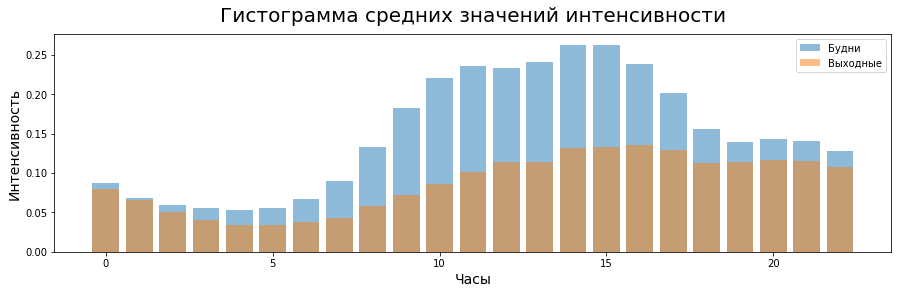

In [761]:
plt.figure(figsize=(15, 4))

plt.bar(np.arange(0, len(work_days_mean)), 
        work_days_mean,
        alpha=0.5,
        label='Будни')

plt.bar(np.arange(0, len(weekends_mean)), 
        weekends_mean, 
        alpha=0.5,
        label='Выходные')

plt.xlabel('Часы', fontsize=14)
plt.ylabel('Интенсивность', fontsize=14)
plt.title ('Гистограмма средних значений интенсивности', 
           y=1.03, fontsize=20) 

plt.legend()
plt.show()

Итого в среднем пик активности достигается между $14:00$ и $16:00$ часов вечера в будние дни и между $14:00$ и $18:00$ для выходных (хотя для выходных во времена с $14:00$ примерно одинаковая интенсивность)

Теперь вполне понятно почему дни, месыцы были не однородными

6) Для получения дополнительных баллов исследуйте, есть ли зависимость интенсивности от типа хоста (`host`); есть ли зависимость объема запроса в байтах от времени; какой пропускной способности должны быть серверы, чтобы обрабатывать все поступающие запросы.